In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Conv1D, MaxPooling1D, LSTM, Bidirectional
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten, Multiply, Lambda, RepeatVector, Permute
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam

import ta
import itertools
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Function to calculate technical indicators using TA-Lib
def calculate_technical_indicators(df):
    """
    Calculate various technical indicators using TA-Lib
    
    Parameters:
    - df: DataFrame with columns 'Open', 'High', 'Low', 'Close', 'Volume'
    
    Returns:
    - DataFrame with technical indicators
    """
    # Price indicators
    df['Returns'] = df['Close'].pct_change()
    df['Log_Returns'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Price_Range'] = df['High'] - df['Low']
    df['Price_Range_Pct'] = df['Price_Range'] / df['Close']
    
    # Moving Averages
    for window in [5, 10, 20, 50, 200]:
        df[f'MA_{window}'] = df['Close'].rolling(window=window).mean()
        df[f'EMA_{window}'] = ta.EMA(df['Close'], timeperiod=window)
        df[f'Returns_{window}d'] = df['Close'].pct_change(periods=window)
    
    # Volatility Metrics
    for window in [5, 10, 20, 50]:
        df[f'Volatility_{window}d'] = df['Returns'].rolling(window=window).std()
        df[f'Volume_MA_{window}d'] = df['Volume'].rolling(window=window).mean()
        df[f'BB_Width_{window}'] = ta.BBANDS(df['Close'], timeperiod=window)[2] - talib.BBANDS(df['Close'], timeperiod=window)[0]
    
    # Technical Indicators
    for period in [9, 14, 25]:
        df[f'RSI_{period}'] = ta.RSI(df['Close'], timeperiod=period)
    
    df['MACD'], df['Signal_Line'], df['MACD_Histogram'] = ta.MACD(df['Close'])
    df['Momentum_14'] = ta.MOM(df['Close'], timeperiod=14)
    df['ROC_14'] = ta.ROC(df['Close'], timeperiod=14)
    
    for period in [14, 28]:
        df[f'MFI_{period}'] = ta.MFI(df['High'], df['Low'], df['Close'], df['Volume'], timeperiod=period)
    
    for period in [20, 50]:
        high_max = df['High'].rolling(window=period).max()
        low_min = df['Low'].rolling(window=period).min()
        df[f'Channel_Width_{period}'] = high_max - low_min
    
    # Volume Indicators
    df['OBV'] = ta.OBV(df['Close'], df['Volume'])
    df['Volume_Ratio'] = df['Volume'] / df['Volume'].rolling(window=20).mean()
    df['Volume_StdDev'] = df['Volume'].rolling(window=20).std()
    
    # Market Features (will be added later from external data)
    
    return df

# Function to optimize technical indicators
def optimize_technical_indicators(data, target, indicators_to_optimize):
    """
    Optimize parameters for technical indicators
    
    Parameters:
    - data: DataFrame with price data
    - target: Target variable (price direction)
    - indicators_to_optimize: Dict of indicators and parameter ranges to test
    
    Returns:
    - Optimized parameters for each indicator
    """
    optimized_params = {}
    
    for indicator, param_grid in indicators_to_optimize.items():
        best_score = 0
        best_params = None
        
        for params in itertools.product(*param_grid.values()):
            param_dict = dict(zip(param_grid.keys(), params))
            
            # Calculate indicator with current parameters
            # Example for RSI optimization
            if indicator == 'RSI':
                timeperiod = param_dict['timeperiod']
                indicator_values = talib.RSI(data['Close'].values, timeperiod=timeperiod)
            # Example for MACD optimization
            elif indicator == 'MACD':
                fastperiod = param_dict['fastperiod']
                slowperiod = param_dict['slowperiod']
                signalperiod = param_dict['signalperiod']
                macd, signal, hist = talib.MACD(data['Close'].values, 
                                              fastperiod=fastperiod, 
                                              slowperiod=slowperiod, 
                                              signalperiod=signalperiod)
                indicator_values = macd
            
            # Skip NaN values for correlation calculation
            valid_indices = ~np.isnan(indicator_values)
            if sum(valid_indices) <= 1:
                continue
                
            if sum(valid_indices) != len(target):
                indicator_values = indicator_values[valid_indices]
                target_subset = target[valid_indices]
            else:
                target_subset = target
            
            # Evaluate correlation with target
            if len(indicator_values) == len(target_subset):
                correlation = np.corrcoef(indicator_values, target_subset)[0, 1]
                
                if abs(correlation) > best_score:
                    best_score = abs(correlation)
                    best_params = param_dict
        
        optimized_params[indicator] = best_params
    
    return optimized_params


In [6]:
# Correlation-Tensor Feature Engineering
def create_correlation_tensor(data, technical_indicators, window_size=30):
    """
    Create correlation tensors from technical indicators
    
    Parameters:
    - data: DataFrame containing technical indicators
    - technical_indicators: List of technical indicator column names
    - window_size: Size of the rolling window for correlation calculation
    
    Returns:
    - Correlation tensor array
    """
    n_samples = len(data) - window_size + 1
    n_features = len(technical_indicators)
    correlation_tensor = np.zeros((n_samples, n_features, n_features))
    
    for i in range(n_samples):
        window_data = data.iloc[i:i+window_size][technical_indicators]
        correlation_matrix = window_data.corr().fillna(0).values
        correlation_tensor[i] = correlation_matrix
    
    return correlation_tensor


In [11]:
# Attention Mechanism
def attention_layer(inputs):
    """
    Implements an attention mechanism for time series data
    
    Parameters:
    - inputs: Time series data tensor
    
    Returns:
    - Attention-weighted feature representation
    """
    # Attention weights calculation
    attention_weights = Dense(1, activation='tanh')(inputs)
    attention_weights = Flatten()(attention_weights)
    attention_weights = Activation('softmax')(attention_weights)
    attention_weights = RepeatVector(inputs.shape[2])(attention_weights)
    attention_weights = Permute([2, 1])(attention_weights)
    
    # Apply attention weights to the input
    attention_output = Multiply()([inputs, attention_weights])
    attention_output = Lambda(lambda x: K.sum(x, axis=1))(attention_output)
    
    return attention_output


In [12]:
# Build the CNN-BiLSTM model with attention
def _build_cnn_bilstm_model(input_shape, num_classes=3):
    """
    Build a CNN-BiLSTM model with attention mechanism for stock prediction
    
    Parameters:
    - input_shape: Shape of input data (time_steps, features)
    - num_classes: Number of output classes (3 for 'up', 'down', 'neutral')
    
    Returns:
    - Compiled Keras model
    """
    # Input layer
    inputs = Input(shape=input_shape)
    
    # CNN Block 1
    x = Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # CNN Block 2
    x = Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # CNN Block 3
    x = Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Bidirectional LSTM layers
    x = Bidirectional(LSTM(units=128, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    x = Bidirectional(LSTM(units=64, return_sequences=True))(x)
    x = Dropout(0.3)(x)
    
    # Attention mechanism
    attention_output = attention_layer(x)
    
    # Dense layers for classification
    x = Dense(64, activation='relu')(attention_output)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create and compile model
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model
def __build_cnn_bilstm_model(input_shape, num_classes=3):
    """Build a CNN-BiLSTM model with attention mechanism for stock prediction"""
    # Input layer
    inputs = Input(shape=input_shape)
    
    # CNN Block 1 - increased filters
    x = Conv1D(filters=128, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    
    # CNN Block 2
    x = Conv1D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    # Bidirectional LSTM layers
    x = Bidirectional(LSTM(units=128, return_sequences=True))(x)
    x = Dropout(0.4)(x)
    x = Bidirectional(LSTM(units=64, return_sequences=False))(x)
    x = Dropout(0.4)(x)
    
    # Dense layers for classification with class-specific attention
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Create and compile model with focal loss
    model = Model(inputs=inputs, outputs=outputs)
    
    # Use a lower learning rate
    optimizer = Adam(learning_rate=0.0005)
    
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

def build_cnn_bilstm_model(input_shape, num_classes=3):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # CNN for pattern extraction
    x = Conv1D(filters=128, kernel_size=3, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    
    # Second CNN layer
    x = Conv1D(filters=256, kernel_size=3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.3)(x)
    
    # Bidirectional LSTM for temporal patterns
    x = Bidirectional(LSTM(units=128, return_sequences=True))(x)
    x = Dropout(0.4)(x)
    x = Bidirectional(LSTM(units=64, return_sequences=False))(x)
    x = Dropout(0.4)(x)
    
    # Dense layers for classification
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [13]:

# Function to prepare sequence data for time series prediction
def _prepare_sequence_data(data, sequence_length, target_col, feature_cols):
    """
    Prepare sequence data for time series prediction
    
    Parameters:
    - data: DataFrame with features and target
    - sequence_length: Length of input sequences
    - target_col: Name of target column
    - feature_cols: List of feature column names
    
    Returns:
    - X: Input sequences
    - y: Target values
    """
    X, y = [], []
    
    for i in range(len(data) - sequence_length):
        X.append(data[feature_cols].iloc[i:i+sequence_length].values)
        
        # Get the target value (next day's price direction)
        target = data[target_col].iloc[i+sequence_length]
        y.append(target)
    
    return np.array(X), np.array(y)
def prepare_sequence_data(df, sequence_length, target_column, feature_columns):
    """
    Prepare sequence data for time series forecasting
    
    Parameters:
    -----------
    df : pandas DataFrame
        The input dataframe containing features and target
    sequence_length : int
        Number of time steps in each sequence
    target_column : str
        Name of the target column
    feature_columns : list
        List of feature column names
    
    Returns:
    --------
    X : numpy array of shape (n_samples, sequence_length, n_features)
        The feature sequences
    y : numpy array of shape (n_samples,)
        The target values
    """
    
    X = []
    y = []
    
    # Extract features and target
    data = df[feature_columns].values
    targets = df[target_column].values
    
    # Create sequences
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(targets[i+sequence_length])
    
    return np.array(X), np.array(y)


In [14]:
# 4. Feature selection to focus on most predictive features
def select_important_features(df, features, target_col='target'):
    """Select most important features using correlation with target"""
    correlations = []
    for feature in features:
        if feature in df.columns:
            # Calculate correlation with target
            corr = np.abs(df[feature].corr(df[target_col]))
            correlations.append((feature, corr))
    
    # Sort by correlation value
    correlations.sort(key=lambda x: x[1], reverse=True)
    
    # Select top 30 features
    top_features = [x[0] for x in correlations[:30]]
    print(f"Selected top {len(top_features)} features")
    return top_features

In [16]:
# Function to train model with class balancing
def _train_model_with_class_balancing(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    """
    Train model with class balancing
    
    Parameters:
    - model: Compiled Keras model
    - X_train, y_train: Training data
    - X_val, y_val: Validation data
    - epochs: Number of training epochs
    - batch_size: Batch size for training
    
    Returns:
    - history: Training history
    - model: Trained model
    """
    # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    )
    
    # Checkpoint to save best model
    model_checkpoint = ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    # Reduce learning rate when a metric has stopped improving
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.0001,
        verbose=1
    )
    
    # Train model with class weights
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight_dict,
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        verbose=1
    )
    
    return history, model
def _2_train_model_with_class_balancing(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    """
    Train the model with class balancing using class weights.
    
    Parameters:
    -----------
    model : keras model
        The model to train
    X_train, y_train : numpy arrays
        Training data
    X_val, y_val : numpy arrays
        Validation data
    epochs : int
        Number of training epochs
    batch_size : int
        Batch size for training
        
    Returns:
    --------
    history : training history
    model : trained model
    """
    # Convert y_train to integer labels (from one-hot encoded)
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        y_train_labels = np.argmax(y_train, axis=1)
    else:
        y_train_labels = y_train.copy()
    
    # Compute class weights
    class_weights = compute_class_weight('balanced', 
                                        classes=np.unique(y_train_labels),
                                        y=y_train_labels)
    
    # Convert to dictionary
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weight_dict,
        callbacks=[
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
        ],
        verbose=1
    )
    
    return history, model
# 3. Improved training function with additional techniques for imbalanced data
def _3train_model_with_class_balancing(model, X_train, y_train, X_val, y_val, epochs=150, batch_size=64):
    """Train model with enhanced class balancing techniques"""
    # Convert y_train to integer labels (from one-hot encoded)
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        y_train_labels = np.argmax(y_train, axis=1)
    else:
        y_train_labels = y_train.copy()
    
    # Compute class weights with more emphasis on minority classes
    class_counts = np.bincount(y_train_labels)
    total_samples = len(y_train_labels)
    class_weights = {
        i: (total_samples / (len(np.unique(y_train_labels)) * count)) * 1.5 
        if i != 1 else (total_samples / (len(np.unique(y_train_labels)) * count))
        for i, count in enumerate(class_counts)
    }
    
    # Enhanced callbacks
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1),
        ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
    ]
    
    # Train with more epochs and larger batch size
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
    
    return history, model

def train_model_with_class_balancing(model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
    # Convert to integer labels if one-hot encoded
    if len(y_train.shape) > 1 and y_train.shape[1] > 1:
        y_train_labels = np.argmax(y_train, axis=1)
    else:
        y_train_labels = y_train.copy()
    
    # Compute class weights with emphasis on minority classes
    class_counts = np.bincount(y_train_labels)
    total_samples = len(y_train_labels)
    class_weights = {
        i: (total_samples / (len(np.unique(y_train_labels)) * count)) * 1.5 
        if i != 1 else (total_samples / (len(np.unique(y_train_labels)) * count))
        for i, count in enumerate(class_counts)
    }
    
    # Callbacks for optimization
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6),
        ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
    ]
    
    # Train with class weighting
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size,
        class_weight=class_weights,
        callbacks=callbacks,
        verbose=1
    )
    
    return history, model

In [17]:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test):
    """
    Evaluate model performance
    
    Parameters:
    - model: Trained model
    - X_test, y_test: Test data
    
    Returns:
    - Dictionary of evaluation metrics
    """
    # Get model predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Convert one-hot encoded targets back to class indices
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test
    
    # Calculate evaluation metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Print classification report
    print(classification_report(y_true, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm
    }

# Function to plot training history
def plot_training_history(history):
    """
    Plot training history
    
    Parameters:
    - history: Training history object
    """
    # Plot training & validation accuracy
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    plt.tight_layout()
    plt.show()


In [18]:

# Function to calculate trading signals and financial metrics
def _generate_trading_signals(model, X_test, df_test, threshold=0.6):
    """
    Generate trading signals based on model predictions
    
    Parameters:
    - model: Trained model
    - X_test: Test features
    - df_test: Test DataFrame with price data
    - threshold: Confidence threshold for trading signals
    
    Returns:
    - DataFrame with trading signals and performance metrics
    """
    # Get model predictions
    y_pred_proba = model.predict(X_test)
    
    # Create a DataFrame with trading signals
    signals = pd.DataFrame(index=df_test.index[-len(X_test):])
    signals['price'] = df_test['Close'][-len(X_test):].values
    signals['up_proba'] = y_pred_proba[:, 2]  # Probability of price going up
    signals['down_proba'] = y_pred_proba[:, 0]  # Probability of price going down
    signals['neutral_proba'] = y_pred_proba[:, 1]  # Probability of price staying neutral
    
    # Generate trading signals
    signals['signal'] = 0  # 0: hold, 1: buy, -1: sell
    signals.loc[signals['up_proba'] > threshold, 'signal'] = 1
    signals.loc[signals['down_proba'] > threshold, 'signal'] = -1
    
    # Calculate returns
    signals['returns'] = signals['price'].pct_change()
    signals['strategy_returns'] = signals['returns'] * signals['signal'].shift(1)
    
    # Calculate cumulative returns
    signals['cumulative_returns'] = (1 + signals['returns']).cumprod()
    signals['cumulative_strategy_returns'] = (1 + signals['strategy_returns']).cumprod()
    
    # Calculate trading metrics
    total_trades = (signals['signal'] != signals['signal'].shift(1)).sum()
    winning_trades = (signals['strategy_returns'] > 0).sum()
    losing_trades = (signals['strategy_returns'] < 0).sum()
    
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    profit_factor = abs(signals.loc[signals['strategy_returns'] > 0, 'strategy_returns'].sum() / 
                        signals.loc[signals['strategy_returns'] < 0, 'strategy_returns'].sum()) if signals.loc[signals['strategy_returns'] < 0, 'strategy_returns'].sum() != 0 else float('inf')
    
    # Calculate Sharpe ratio (annualized)
    risk_free_rate = 0.02  # Assuming 2% risk-free rate
    sharpe_ratio = (signals['strategy_returns'].mean() * 252 - risk_free_rate) / (signals['strategy_returns'].std() * np.sqrt(252))
    
    # Calculate maximum drawdown
    cumulative_returns = signals['cumulative_strategy_returns']
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / running_max - 1)
    max_drawdown = drawdown.min()
    
    # Print performance metrics
    print(f"Total Trades: {total_trades}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Profit Factor: {profit_factor:.2f}")
    print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
    print(f"Maximum Drawdown: {max_drawdown:.2%}")
    
    # Plot cumulative returns
    plt.figure(figsize=(12, 6))
    plt.plot(signals['cumulative_returns'], label='Buy and Hold')
    plt.plot(signals['cumulative_strategy_returns'], label='Trading Strategy')
    plt.title('Cumulative Returns Comparison')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return signals, {
        'total_trades': total_trades,
        'win_rate': win_rate,
        'profit_factor': profit_factor,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown
    }
def _generate_trading_signals(model, X_test, df_test):
    """
    Generate trading signals from model predictions.
    
    Parameters:
    -----------
    model : keras model
        Trained model
    X_test : numpy array
        Test feature sequences
    df_test : pandas DataFrame
        Test DataFrame with price data
        
    Returns:
    --------
    signals : pandas DataFrame
        DataFrame with trading signals
    performance_metrics : dict
        Trading performance metrics
    """
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Create signals DataFrame
    signals = pd.DataFrame(index=df_test.index[:len(y_pred)])
    signals['predicted_class'] = y_pred
    
    # Define signals: 0 = down, 1 = neutral, 2 = up
    signals['position'] = 0  # Default is no position
    signals.loc[signals['predicted_class'] == 2, 'position'] = 1  # Long position for 'up' prediction
    signals.loc[signals['predicted_class'] == 0, 'position'] = -1  # Short position for 'down' prediction
    
    # Add price data
    signals['price'] = df_test['Close'].values[:len(signals)]
    
    # Calculate returns
    signals['returns'] = np.log(signals['price'] / signals['price'].shift(1))
    signals['strategy_returns'] = signals['position'].shift(1) * signals['returns']
    
    # Calculate performance metrics
    total_return = np.exp(signals['strategy_returns'].sum()) - 1
    annual_return = np.exp(signals['strategy_returns'].mean() * 252) - 1
    sharpe_ratio = np.sqrt(252) * signals['strategy_returns'].mean() / signals['strategy_returns'].std()
    
    performance_metrics = {
        'total_return': total_return,
        'annual_return': annual_return,
        'sharpe_ratio': sharpe_ratio
    }
    
    return signals, performance_metrics

def generate_trading_signals(model, X_test, df_test):
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis=1)
    
    # Create signals DataFrame
    signals = pd.DataFrame(index=df_test.index[:len(y_pred)])
    signals['predicted_class'] = y_pred
    
    # Define positions: 0=down (-1), 1=neutral (0), 2=up (1)
    signals['position'] = 0
    signals.loc[signals['predicted_class'] == 2, 'position'] = 1
    signals.loc[signals['predicted_class'] == 0, 'position'] = -1
    
    # Calculate returns
    signals['price'] = df_test['Close'].values[:len(signals)]
    signals['returns'] = np.log(signals['price'] / signals['price'].shift(1))
    signals['strategy_returns'] = signals['position'].shift(1) * signals['returns']
    
    # Calculate performance metrics
    total_return = np.exp(signals['strategy_returns'].sum()) - 1
    annual_return = np.exp(signals['strategy_returns'].mean() * 252) - 1
    sharpe_ratio = np.sqrt(252) * signals['strategy_returns'].mean() / signals['strategy_returns'].std()
    max_drawdown = (signals['strategy_returns'].cumsum() - 
                   signals['strategy_returns'].cumsum().cummax()).min()
    
    # Win/loss metrics
    signals['trade'] = signals['position'].diff().abs() > 0
    winning_trades = signals[(signals['trade']) & 
                            (signals['strategy_returns'] > 0)]['strategy_returns'].count()
    losing_trades = signals[(signals['trade']) & 
                           (signals['strategy_returns'] < 0)]['strategy_returns'].count()
    win_rate = winning_trades / (winning_trades + losing_trades) if (winning_trades + losing_trades) > 0 else 0
    
    return signals, {
        'total_return': total_return,
        'annual_return': annual_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'win_rate': win_rate
    }


In [19]:
# Load and preprocess data
print("Loading data...")
# Load the S&P 500 data
# Modify the path to your data file
df = pd.read_csv('sp500_master_data.csv', parse_dates=True)

# Convert date column to datetime if needed
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
print("Data loaded successfully.count of rows:", len(df))

Loading data...
Data loaded successfully.count of rows: 622641


In [20]:

print("Preprocessing data...")

# Handle missing values
print(f"Missing values before imputation: {df.isna().sum().sum()}")
# Fill missing values in technical indicators with forward fill then backward fill
df.fillna(method='ffill', inplace=True)
df.fillna(method='bfill', inplace=True)
# Any remaining NaNs replace with 0
df.fillna(0, inplace=True)
print(f"Missing values after imputation: {df.isna().sum().sum()}")


Preprocessing data...
Missing values before imputation: 900919
Missing values after imputation: 0


In [21]:

# Create target variable - Price direction classification
# 2: Up, 1: Neutral, 0: Down
#price_change_threshold = 0.005  # 0.5% threshold
#df['target'] = np.where(df['Returns'].shift(-1) > price_change_threshold, 2,
#                        np.where(df['Returns'].shift(-1) < -price_change_threshold, 0, 1))

price_change_threshold = 0.003  # Reduced from 0.005 to create more balanced classes
df['target'] = np.where(df['Returns'].shift(-1) > price_change_threshold, 2,
                        np.where(df['Returns'].shift(-1) < -price_change_threshold, 0, 1))
# Remove rows with NaN in target (last row will have NaN)
df = df.dropna(subset=['target'])

# Convert target to int
df['target'] = df['target'].astype(int)

# Define features to use from available columns
# Select price indicators
price_indicators = ['Close', 'Returns', 'Log_Returns', 'Price_Range', 'Price_Range_Pct']

# Select moving averages
moving_averages = [col for col in df.columns if col.startswith('MA_') or 
                    col.startswith('EMA_') or col.startswith('Returns_')]

# Select volatility metrics
volatility_metrics = [col for col in df.columns if col.startswith('Volatility_') or 
                        col.startswith('Volume_MA_') or col.startswith('BB_Width_')]

# Select technical indicators
technical_indicators = ['RSI_9', 'RSI_14', 'RSI_25', 'MACD', 'Signal_Line', 'MACD_Histogram',
                        'Momentum_14', 'ROC_14', 'MFI_14', 'MFI_28'] + \
                        [col for col in df.columns if col.startswith('Channel_Width_')]

# Select volume indicators
volume_indicators = ['OBV', 'Volume_Ratio', 'Volume_StdDev']

# Select fundamental features
fundamental_features = ['PE_Ratio', 'PB_Ratio', 'Dividend_Yield', 'Profit_Margin', 
                        'Beta', 'Enterprise_Value', 'Forward_EPS', 'Trailing_EPS']

# Select market features
market_features = ['Market_Return', 'Market_Volatility', 'Rolling_Beta', 'VIX', 'VIX_MA_10']

# Combine all features
all_features = price_indicators + moving_averages + volatility_metrics + \
                technical_indicators + volume_indicators + \
                fundamental_features + market_features

# Remove any features not in the dataframe
features = [f for f in all_features if f in df.columns]
print(f"Using {len(features)} features: {features[:5]}...")


Using 56 features: ['Close', 'Returns', 'Log_Returns', 'Price_Range', 'Price_Range_Pct']...


In [22]:
# Create correlation tensor features
print("Creating correlation tensor features...")
# Select a subset of important technical indicators for correlation tensor
tensor_indicators = ['RSI_14', 'MACD', 'Momentum_14', 'ROC_14', 'MFI_14',    'Volume_Ratio', 'Returns', 'Volatility_20d']
tensor_indicators = [ind for ind in tensor_indicators if ind in df.columns]

correlation_tensor = create_correlation_tensor(df, tensor_indicators, window_size=30)
print(f"Correlation tensor shape: {correlation_tensor.shape}")


Creating correlation tensor features...
Correlation tensor shape: (622612, 8, 8)


In [78]:
# Prepare sequence data
print("Preparing sequence data...")
sequence_length = 30  # 30 days of historical data
selected_features = select_important_features(df, features)
X, y = prepare_sequence_data(df, sequence_length, 'target', selected_features)
#X, y = prepare_sequence_data(df, sequence_length, 'target', features)
print(f"X shape: {X.shape}, y shape: {y.shape}")


Preparing sequence data...
Selected top 30 features


: 

: 

In [ ]:

# Convert target to one-hot encoding
y_onehot = tf.keras.utils.to_categorical(y, num_classes=3)


In [ ]:

# Split data using time series split
print("Splitting data...")
# Use a time series split to respect the temporal nature of the data
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y_onehot[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y_onehot[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y_onehot[train_size+val_size:]

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")


Splitting data...
Training set: (30400, 30, 30), (30400, 3)
Validation set: (6514, 30, 30), (6514, 3)
Testing set: (6516, 30, 30), (6516, 3)


In [ ]:
# Check class distribution
print("Class distribution in training set:")
class_counts = np.sum(y_train, axis=0)
print(f"Down: {class_counts[0]}, Neutral: {class_counts[1]}, Up: {class_counts[2]}")


Class distribution in training set:
Down: 11813.0, Neutral: 5055.0, Up: 13532.0


In [ ]:
# Build and train model
print("Building and training model...")
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_cnn_bilstm_model(input_shape, num_classes=3)
model.summary()


Building and training model...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 30, 30)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 30, 128)        │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 30, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 15, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 15, 256)        │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 15, 256)        │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 15, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 7, 256)         │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 7, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 678,787 (2.59 MB)

 Trainable params: 678,019 (2.59 MB)

 Non-trainable params: 768 (3.00 KB)

In [ ]:
history, model = train_model_with_class_balancing(
    model, X_train, y_train, X_val, y_val, epochs=100, batch_size=32
)


Epoch 1/100
949/950 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3973 - loss: 1.4630
Epoch 1: val_loss improved from inf to 1.04190, saving model to best_model.keras
950/950 ━━━━━━━━━━━━━━━━━━━━ 42s 40ms/step - accuracy: 0.3973 - loss: 1.4630 - val_accuracy: 0.4150 - val_loss: 1.0419 - learning_rate: 5.0000e-04
Epoch 2/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4282 - loss: 1.4452
Epoch 2: val_loss did not improve from 1.04190
950/950 ━━━━━━━━━━━━━━━━━━━━ 43s 42ms/step - accuracy: 0.4282 - loss: 1.4452 - val_accuracy: 0.4125 - val_loss: 1.0479 - learning_rate: 5.0000e-04
Epoch 3/100
950/950 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4365 - loss: 1.4387
Epoch 3: val_loss improved from 1.04190 to 1.03531, saving model to best_model.keras
950/950 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.4365 - loss: 1.4387 - val_accuracy: 0.4245 - val_loss: 1.0353 - learning_rate: 5.0000e-04
Epoch 4/100
949/950 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.4335 - loss: 1

KeyboardInterrupt: 

Evaluating model...
204/204 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
              precision    recall  f1-score   support

           0       0.45      0.00      0.00      2264
           1       0.26      1.00      0.41      1690
           2       0.62      0.01      0.03      2562

    accuracy                           0.26      6516
   macro avg       0.45      0.34      0.15      6516
weighted avg       0.47      0.26      0.12      6516



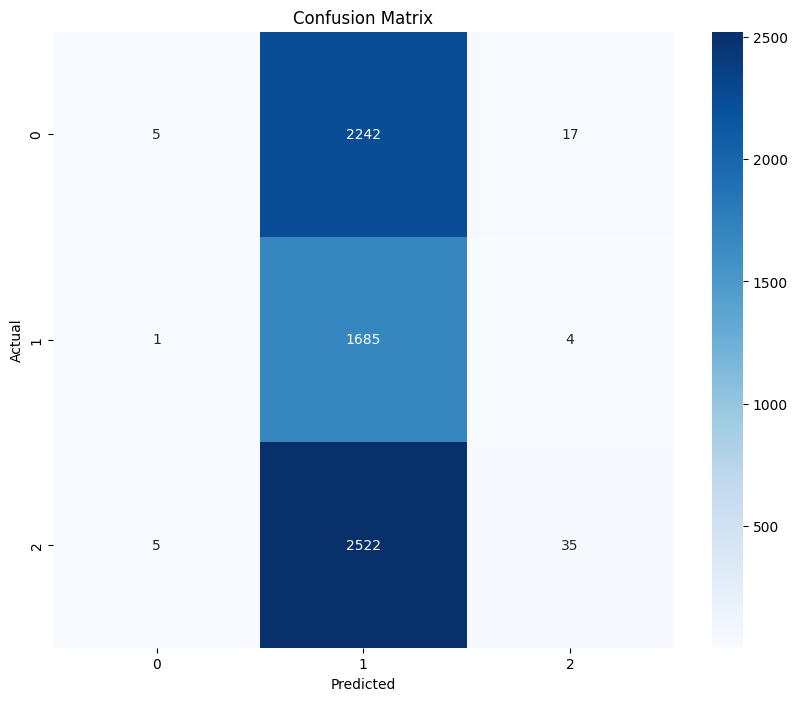

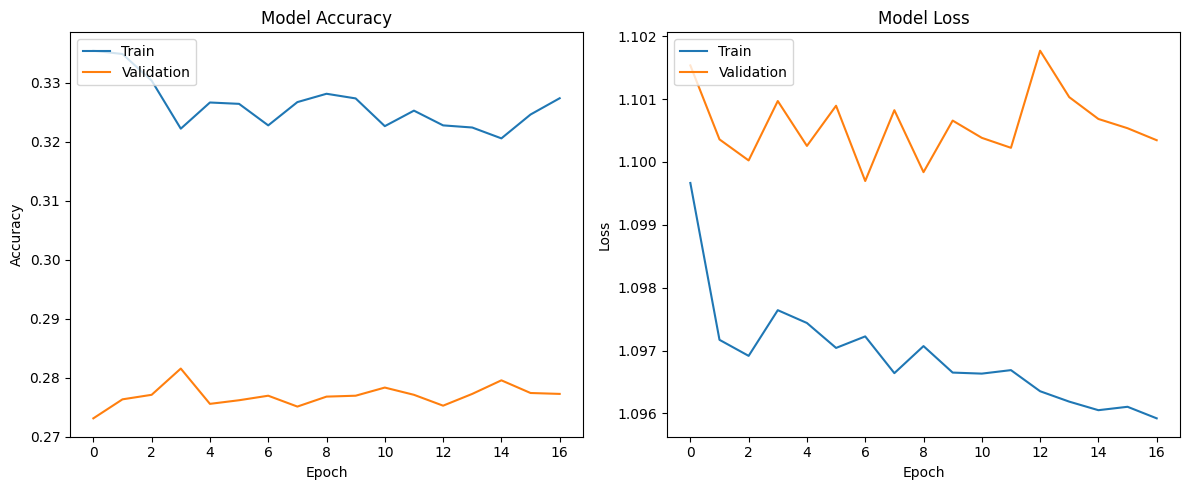

Generating trading signals...
204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Workflow completed.


In [ ]:

# Evaluate model
print("Evaluating model...")
evaluation_metrics = evaluate_model(model, X_test, y_test)
plot_training_history(history)

# Generate trading signals
print("Generating trading signals...")
df_test = df.iloc[train_size+val_size+sequence_length:]
signals, performance_metrics = generate_trading_signals(model, X_test, df_test)

print("Workflow completed.")